# Portfolio Analysis of Communication services sector

### Stocks under observation:

    - Walt Disney Co. (NASDAQ: DIS)
    - Zoom Video Communications Inc (NASDAQ: ZM)
    - Netflix (NASDAQ:NFLX) 
    - Facebook (NASDAQ:FB)
    - Alphabet (NASDAQ:GOOGL)
    - Verizon (NYSE:VZ) 

In [22]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as wb
import scipy.optimize as sco
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Pulling stock data 

In [23]:
comms = ['DIS', 'ZM', 'NFLX', 'FB','GOOGL', 'VZ' ]
data = pd.DataFrame()
for i in range(len(comms)):
    
    df = wb.DataReader(comms[i], data_source='yahoo', start='2020-1-1')
    df['stock'] = comms[i]
    data = data.append(df[['Adj Close', 'stock']])

table = data.pivot(columns='stock')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,DIS,FB,GOOGL,NFLX,VZ,ZM
Date,,,,,,
2020-01-02,148.199997,209.779999,1368.680054,329.809998,59.778305,68.720001
2020-01-03,146.500000,208.669998,1361.520020,325.899994,59.141846,67.279999
2020-01-06,145.649994,212.600006,1397.810059,335.829987,59.014557,70.320000
2020-01-07,145.699997,213.059998,1395.109985,330.750000,58.358509,71.900002
2020-01-08,145.399994,215.220001,1405.040039,339.260010,58.466221,72.550003


Text(0, 0.5, 'price in $')

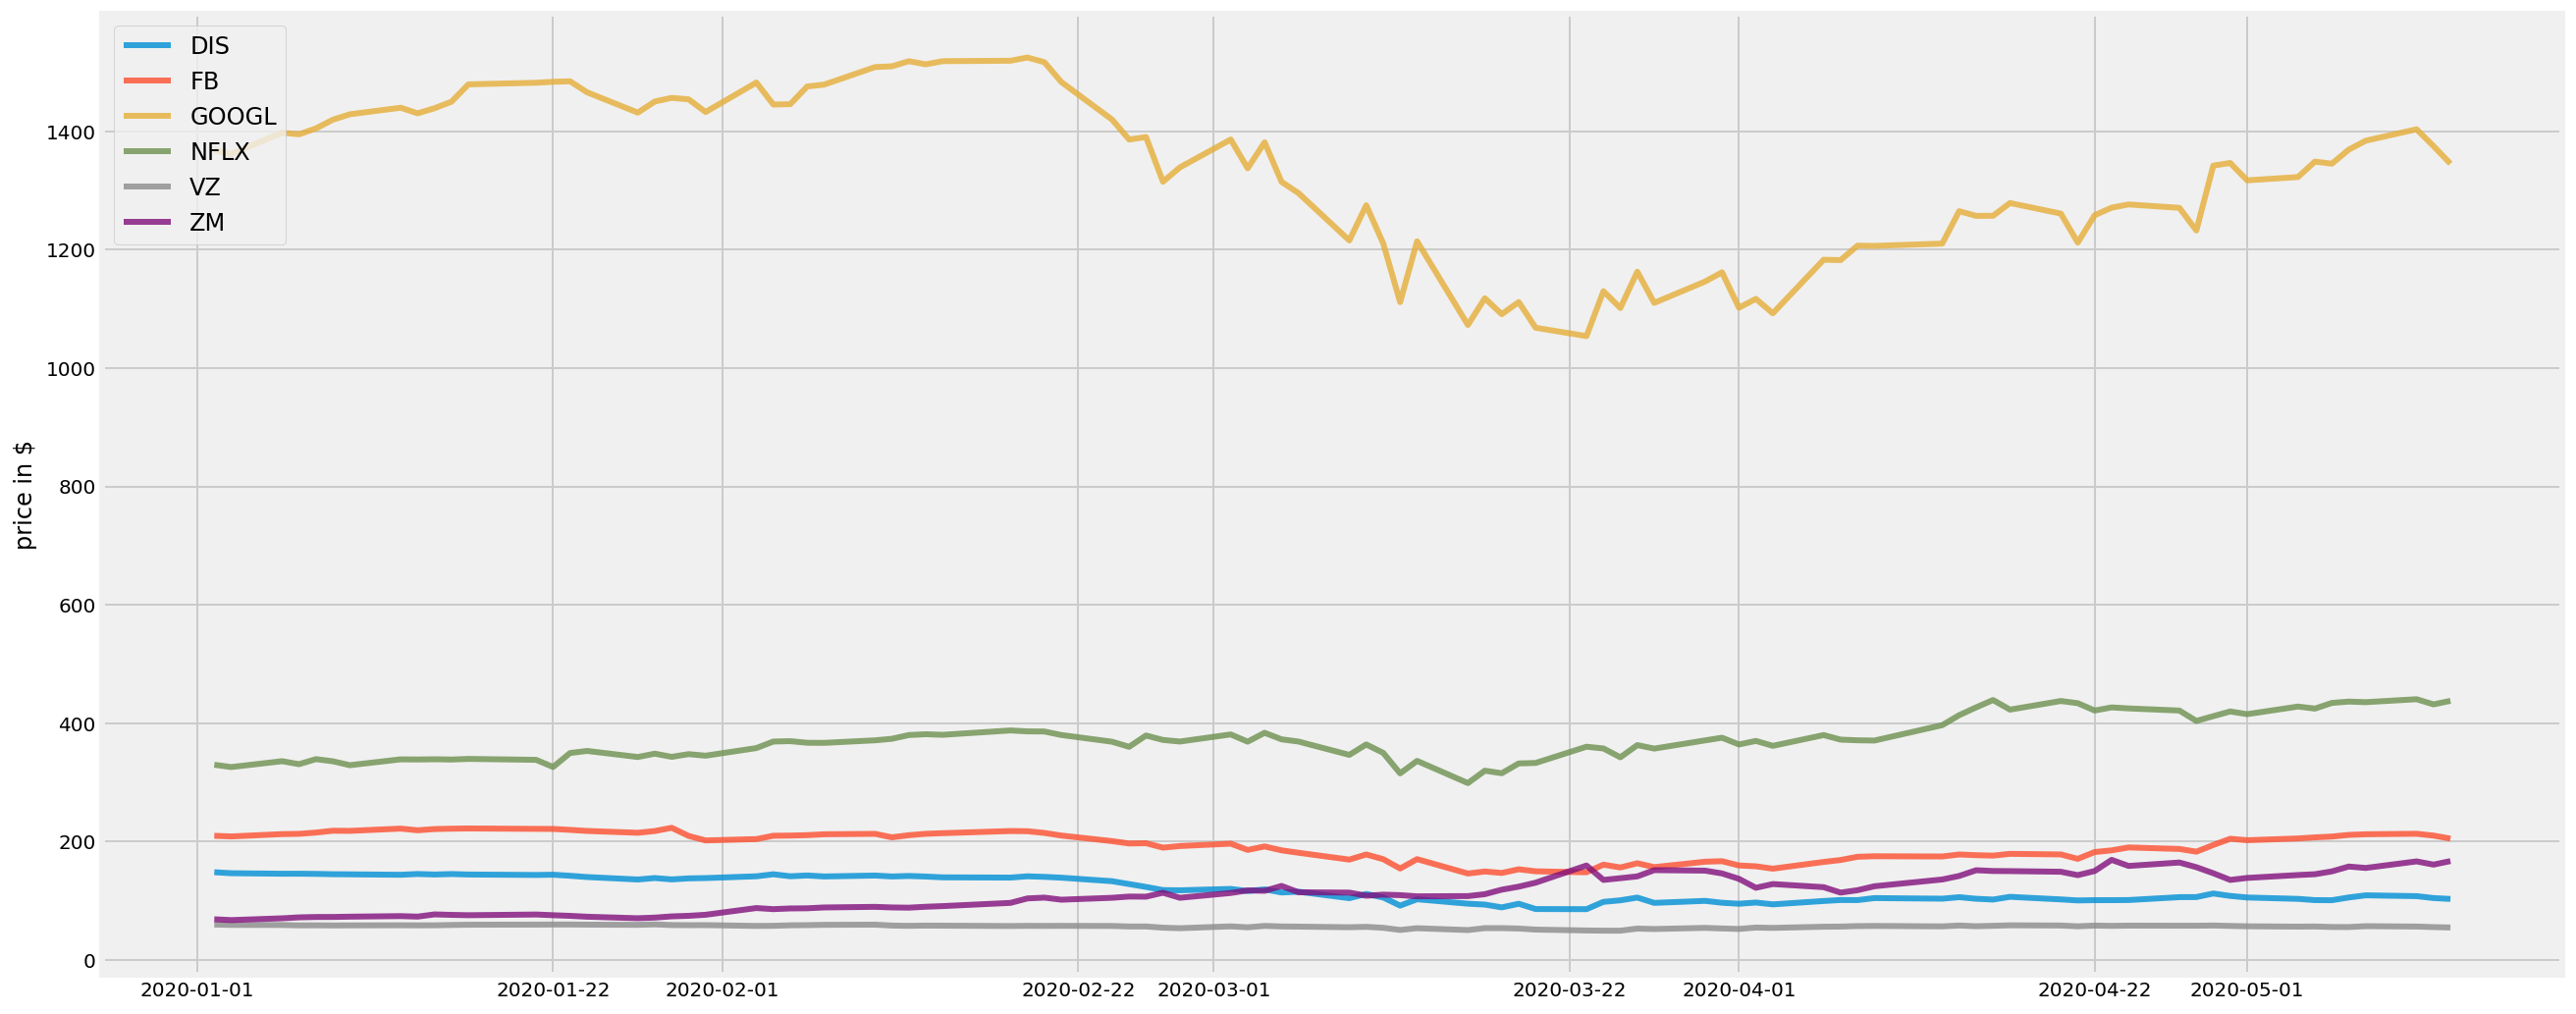

In [24]:
plt.figure(figsize=(20, 9))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

### Simple returns

Text(0, 0.5, 'daily returns')

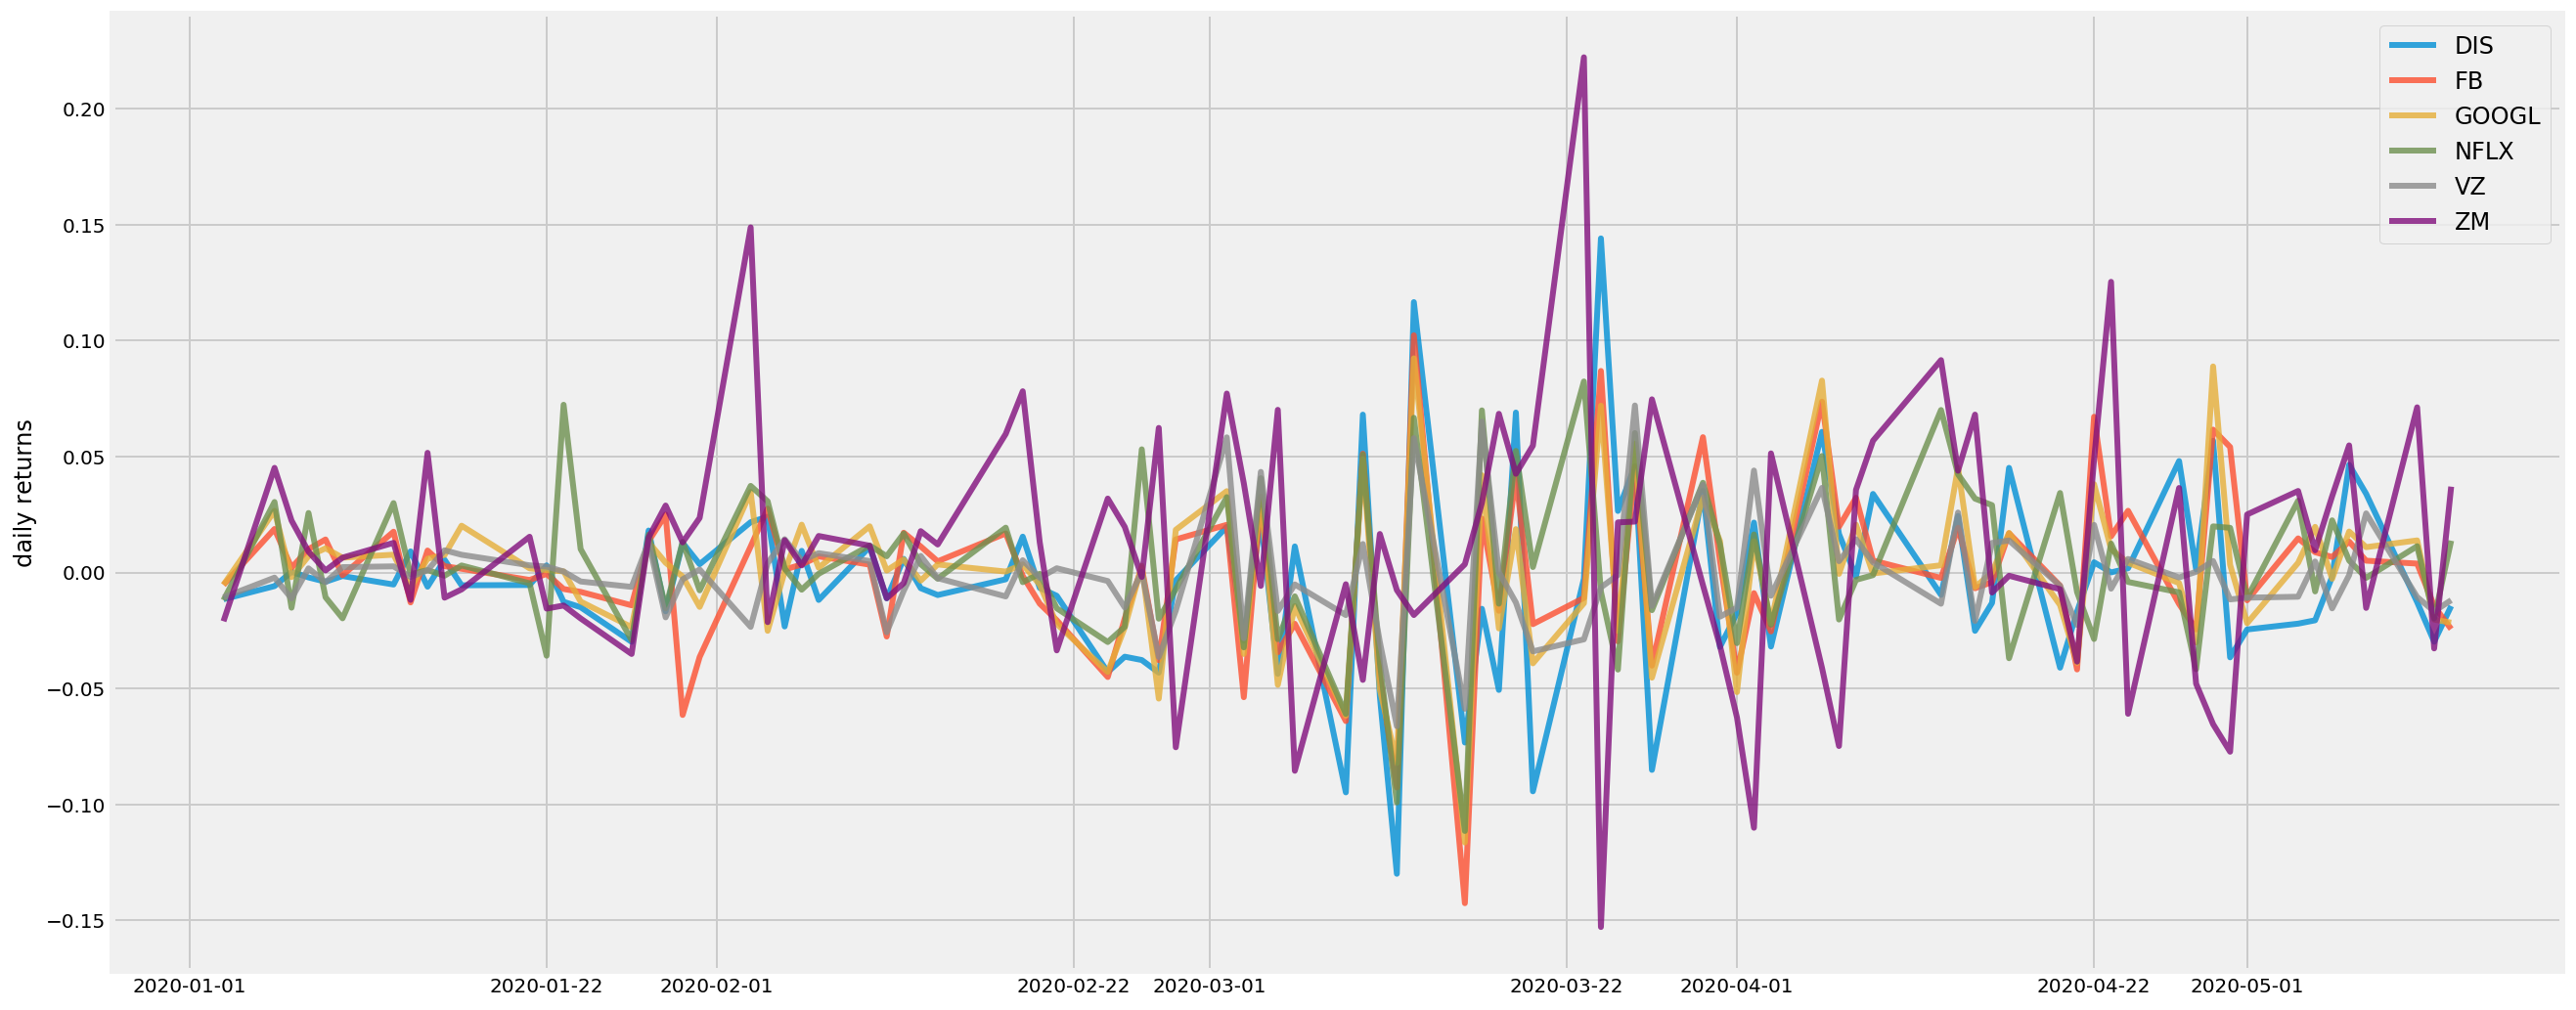

In [25]:
returns = table.pct_change()
plt.figure(figsize=(20, 9))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

### log returns

Text(0, 0.5, 'daily log returns')

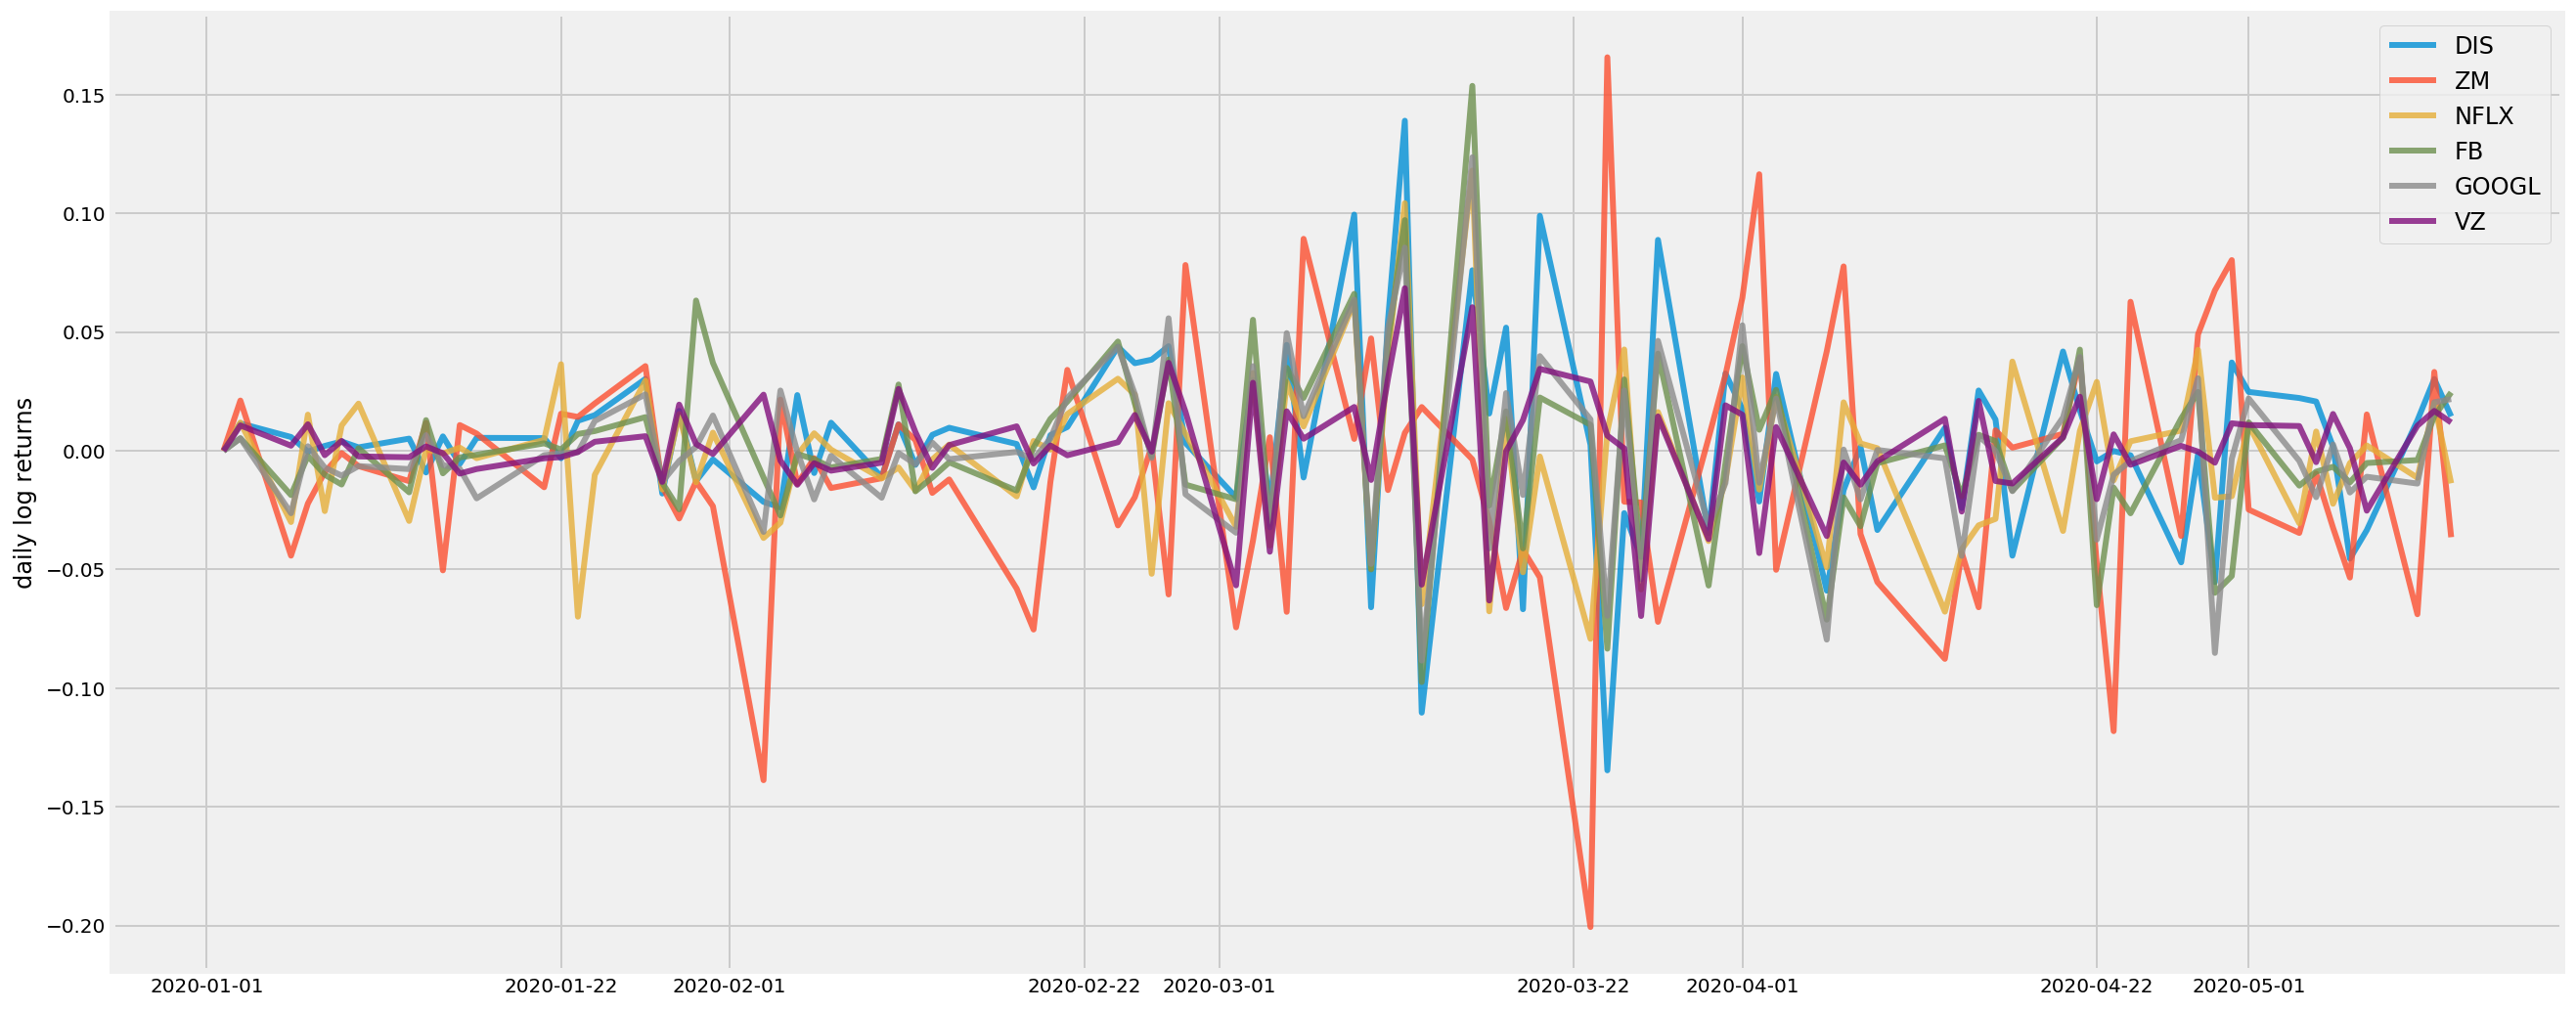

In [26]:
log = pd.DataFrame(columns = comms, index = table.index)

for i in range(len(comms)):
    log_list = []
    for j in range(len(table[comms[i]])):
        if(j+1<len(table[comms[i]])):
            log_returns =  np.log(table[comms[i]][j]) - np.log(table[comms[i]][j+1])
            log_list.append(log_returns)
            

        else:
            None
    log_list.insert(0, 0)   
    log[comms[i]] = log_list


plt.figure(figsize=(20, 9))
for c in log.columns.values:
     plt.plot(log.index, log[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily log returns')


### Normalization to 100

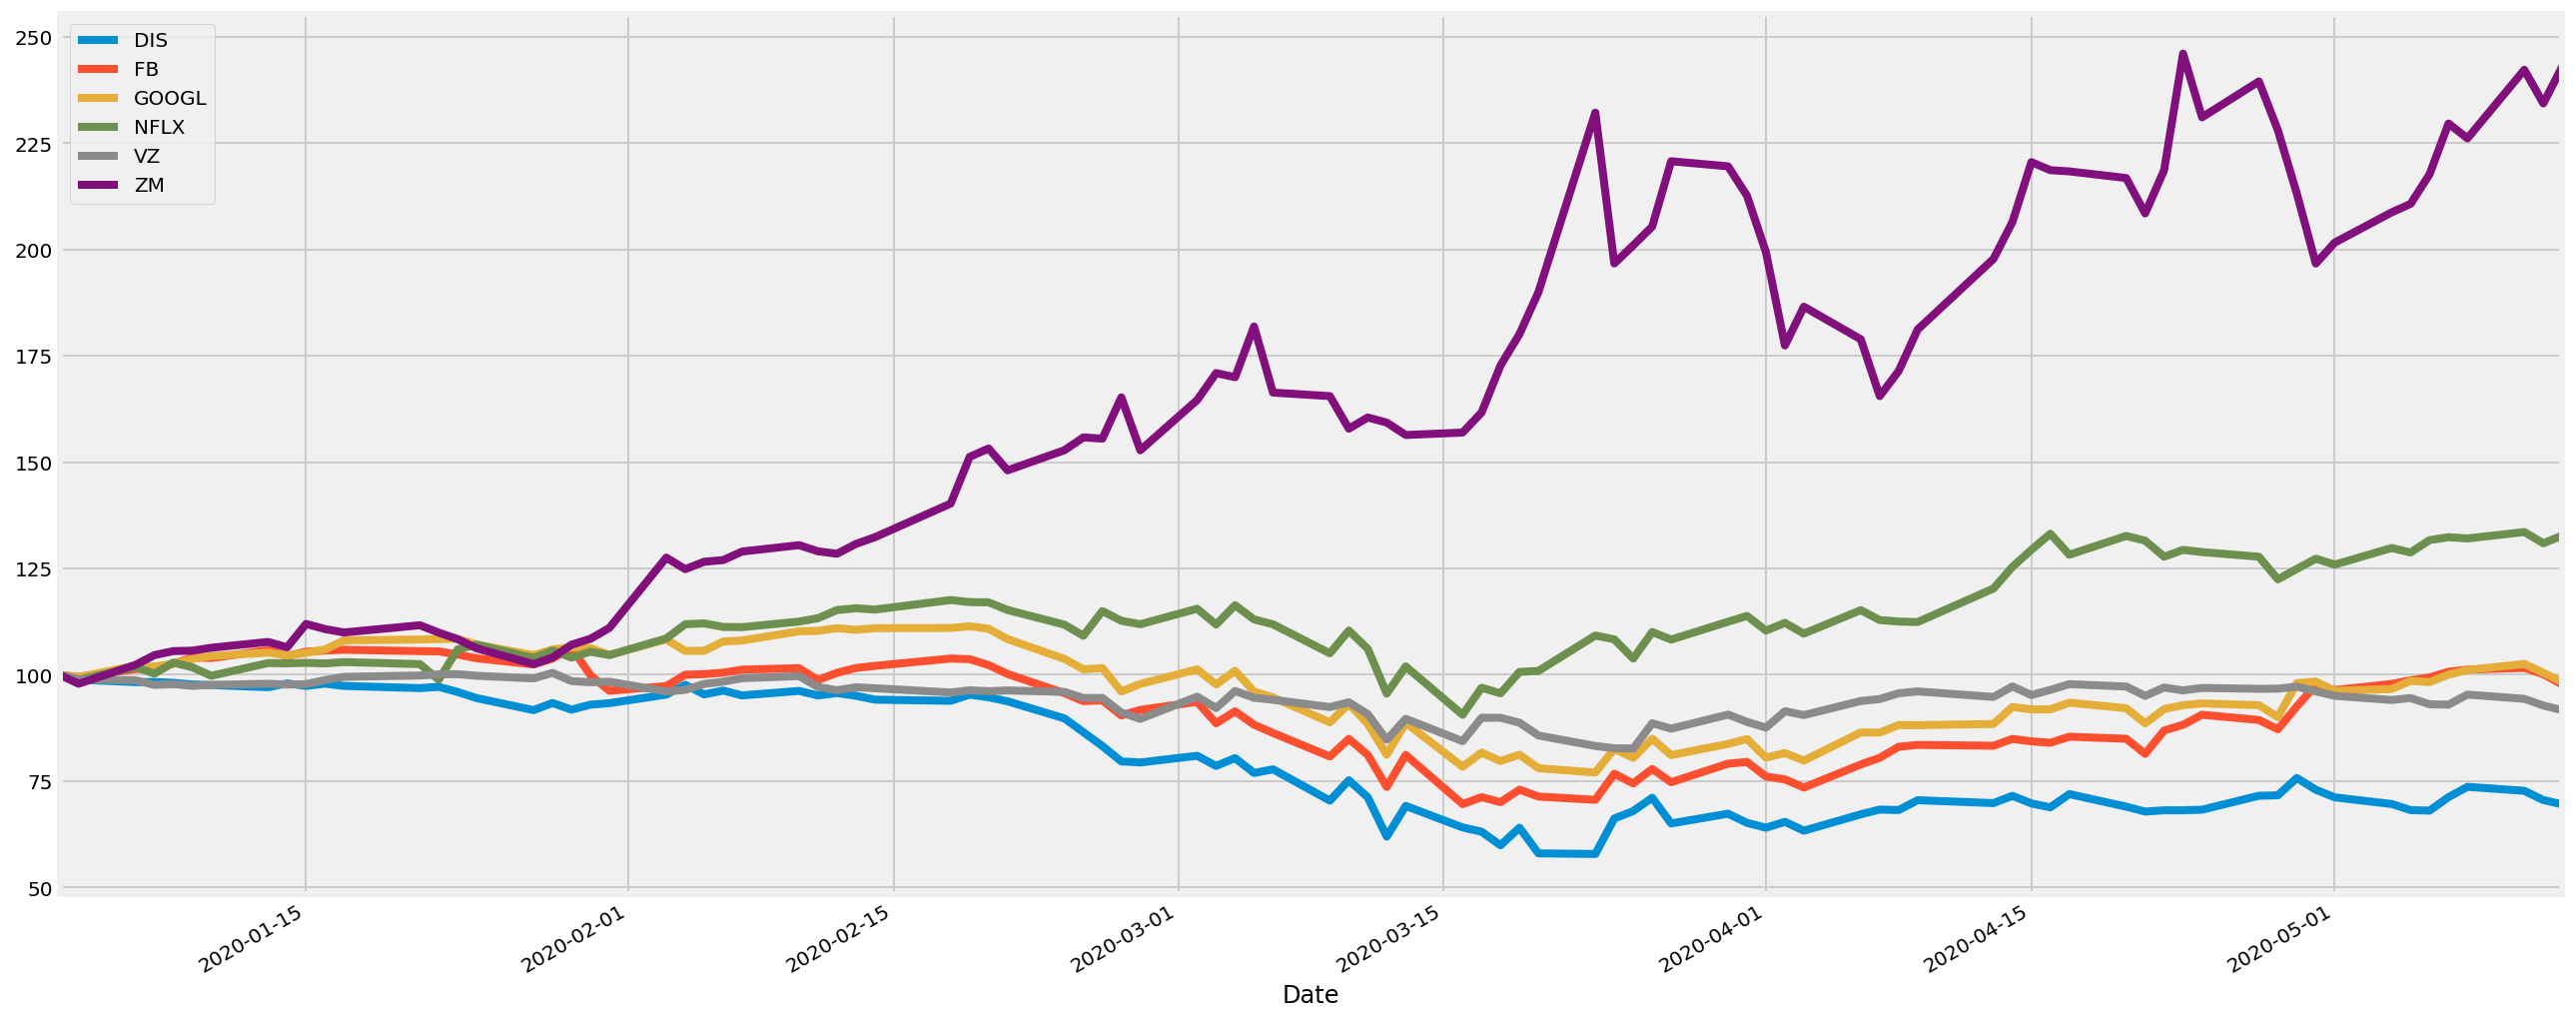

In [27]:
(table/table.iloc[0] * 100).plot(figsize = (20,9))
plt.show()

In [28]:
returns

,DIS,FB,GOOGL,NFLX,VZ,ZM
Date,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.011471,-0.005291,-0.005231,-0.011855,-0.010647,-0.020955
2020-01-06,-0.005802,0.018834,0.026654,0.030469,-0.002152,0.045184
2020-01-07,0.000343,0.002164,-0.001932,-0.015127,-0.011117,0.022469
2020-01-08,-0.002059,0.010138,0.007118,0.025729,0.001846,0.009040
...,...,...,...,...,...,...
2020-05-07,0.046491,0.013383,0.017727,0.005227,-0.001078,0.054883
2020-05-08,0.034006,0.005160,0.010998,-0.002245,0.025549,-0.015209
2020-05-11,-0.012734,0.003909,0.013906,0.011411,-0.010526,0.071300


In [29]:
log.mean()*252

DIS      0.995126
ZM      -2.432384
NFLX    -0.775658
FB       0.063210
GOOGL    0.046706
VZ       0.238090
dtype: float64

In [30]:
log.std()*252**0.5

DIS      0.627048
ZM       0.827576
NFLX     0.532202
FB       0.567273
GOOGL    0.526369
VZ       0.353345
dtype: float64